# Project setup

Run the cells below to get started.

In [ ]:
# @title Install required packages
!pip install mne openai-clip scikit-learn pandas numpy torch xgboost dill braindecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368629 sha256=695d16e28b4dace2c8c5adfe21881e32ec776a666c7a0ba4ab8dbbbd826a7160
  Stored in directory: /root/.cache/pip/wheels/ab/49/bc/c2342e8e14878210ba4825cf314a53f2570f6fb18b91fce3cf
Successfully built openai-clip


# EEG Decoding

In [18]:
# @title Import modules and load data

import mne
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import clip
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from autoreject import AutoReject                           # added this
from scipy import stats                                     # added this
from mne.stats import spatio_temporal_cluster_test          # added this   
from mne.channels import find_ch_adjacency                  # added this 
from autoreject import get_rejection_threshold              # added this
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from mne.preprocessing import ICA


In [ ]:
DATA_DIR = Path('data/zip/')

raw = mne.io.read_raw_brainvision(DATA_DIR / "data.vhdr", preload=True, verbose=False)
raw.resample(250, verbose=False)  # Downsample to 250 Hz

metadata = pd.read_parquet(DATA_DIR / "metadata.parquet")

'''
- Removed a 'misc' channel and retained only the EEG channels (since this is an EEG analysis task)
- Re-referenced the data with respect to average
'''

raw.pick('eeg')                             # there seems to be a 'misc' channel; I'm dropping it and considering only the 31 EEG channels

# autoreject (used later) needs montage
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
raw.set_eeg_reference('average')            # doing re-referencing to average

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | data.eeg, 31 x 1535500 (6142.0 s), ~363.2 MiB, data loaded>

In [11]:
org_raw = raw.copy()

In [4]:
annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)

event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)

# Align metadata with events (bottom-up alignment)
metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values
print(f"Found {len(events)} stimulus events")

# Create epochs with baseline correction
epochs = mne.Epochs(raw.copy().filter(0.1, 30), events, tmin=0.0, tmax=1.0, baseline=None, preload=True, verbose=False, metadata=metadata_aligned)       # applied band pass filtering here
epochs.save('epochs.fif', overwrite=True)

Found 20880 stimulus events
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Overwriting existing file.


/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/2161517038.py:15: RuntimeWarning: This filename (epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save('epochs.fif', overwrite=True)


Overwriting existing file.
Overwriting existing file.


[PosixPath('/Users/soumilray/Documents/Projects/Alljoined/epochs.fif')]

In [ ]:
def plot_better(raw, start=0, duration=1, figsize=(12, 8)):
    '''
    Plots a segment (defined by start time and duration) of EEG data

    Args:
      raw = Instance of Raw class (MNE)
      start = start time of the second in seconds
      duration = duration of the segment in seconds
      figsize is for plotting

      - Applied a band pass filter (high pass: 0.1 Hz, low pass: 30 Hz), which is what should generally be done according to the author of neuraldatascience.io;
          The original data has high pass:0, low pass:125
          The high pass removes slow drift, and low pass likely filters out noise
    '''


    assert start >= 0, "Start time must be >=0"
    assert duration >=0, "Duration cannot be negative"

    sfreq = raw.info['sfreq']                   # sampling frequency
    start_idx = int(start * sfreq)              # start (in terms of data sample number)
    end_idx = int((start + duration) * sfreq)   # end (in terms of data sample number)

    raw.filter(l_freq=0.1, h_freq=30)         # applying band pass filter to eliminate some noise and slow drift

    data, times = raw[:, start_idx:end_idx]   # all channels, samples from specified duration

    data = data * 1e6   # scaling to uV
    spacing = 100    

    fig, ax = plt.subplots(figsize=figsize)

    offset = np.arange(len(data)) * spacing

    # Plot each channel
    for i, channel_data in enumerate(data):   
        ax.plot(times, channel_data + offset[i], linewidth=0.5,
                label=raw.ch_names[i] if i < 3 else "")

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channels')
    ax.set_title(f'{start}s - {start+duration}s')
    ax.set_yticks(offset)
    ax.set_yticklabels(raw.ch_names)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig, ax

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)



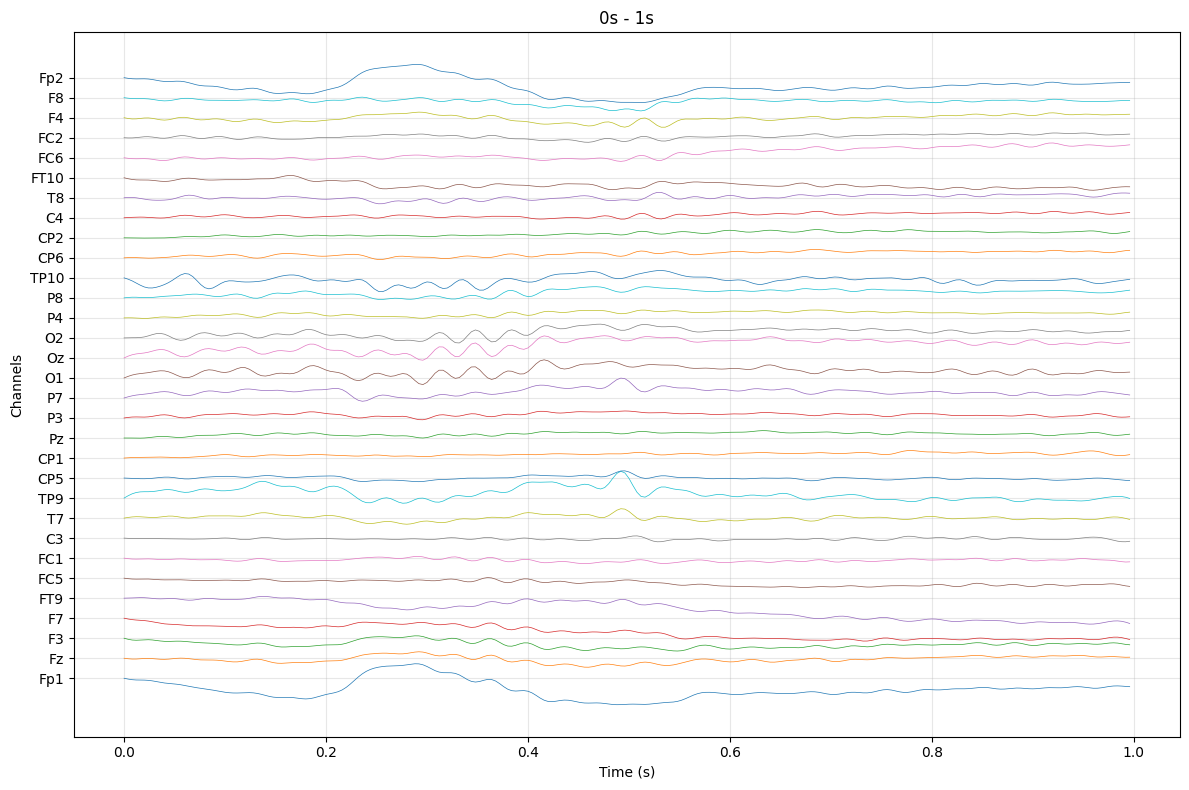

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': '0s - 1s'}, xlabel='Time (s)', ylabel='Channels'>)

In [ ]:
plot_better(raw.copy(), start=0, duration=1)

# Data Preprocessing

Failed approach:
* Identify bad epochs with autoreject
* Apply ICA on epochs that weren't flagged by autoreject
* Remove bad epochs by doing autoreject again
* I had to give up on tihs approach because the fit_transform method in the second AR run was taking too long. I tried fitting on a subset of the data and then transforming the entire data, but that took too long as well. I had let the program run for a couple of hours

Approach 1:
* Identify bad epochs with autoreject
* Apply ICA on epochs not flagged by autoreject

Approach 2:
* Apply ICA

Approach 3:
* Similar to the failed approach described above, but I used get_rejection_threshold instead of autoreject

In [ ]:
def preprocess_data_1(raw):

  '''
  Changes:
  - Applied a band pass filter (high pass: 0.1 Hz, low pass: 30 Hz), which is what should generally be done according to the author of neuraldatascience.io;
      The original data has high pass:0, low pass:125
      The high pass removes slow drift, and low pass likely filters out noise
  - The band pass filter for ICA has been applied with different limits because we need stricter low frequency filtering
  - Applied ICA
  - (I wanted to apply autorejct after ICA too, but it was taking too long to run)
  '''

  # A band pass filter has already been applied on epochs above
  # 0.1 - 30 Hz (to remove slow drift and noise)

  # ICA
  raw_ica = raw.copy().filter(1, 30)   # for ICA, we should filter out more low frequency power compared to the raw data
  # Breaking into epochs (consecutive, not event related) for ICA
  tstep = 5.0   # chose 5s to make autoreject time bearable
  events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
  epochs_ica = mne.Epochs(raw_ica, events_ica, tmin=0.0, tmax=tstep, baseline=None, preload=True)

  # Doing autoreject to remove one-off large noises, since ICA focuses on separating periodic signals
  ar = AutoReject(n_interpolate=[1], random_state=42, picks=mne.pick_types(epochs_ica.info, eeg=True, eog=False), verbose=True, cv=5) # reducing cv from default 10 to 5 to reduce preprocessing time
  ar.fit(epochs_ica)
  reject_log = ar.get_reject_log(epochs_ica)

  # Doing ICA on data without removing the autoreject flagged portions
  ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)   # want 99% of the variance to be explained
  ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

  ica.exclude = []
  num_excl = 0
  max_ic = 2
  z_thresh = 3.5
  z_step = .05
  while (num_excl < max_ic) and (z_thresh > 0.5):
      eog_indices, eog_scores = ica.find_bads_eog(epochs_ica, ch_name=['Fp1', 'Fp2', 'F7', 'F8'], threshold=z_thresh)
      num_excl = len(eog_indices)
      z_thresh -= z_step
      print(z_thresh)
  ica.exclude = eog_indices
  print('Final z threshold = ' + str(round(z_thresh, 2)))

  epochs_postica = ica.apply(epochs.copy())      # the 0.1-30 Hz band pass filter should implicitly come here (was done above)
  epochs_postica.save('prep_epochs_1.fif', overwrite=True)

  # ar = AutoReject(n_interpolate=[1], random_state=42, picks=mne.pick_types(epochs_postica.info, eeg=True, eog=False), verbose=True, cv=5)
  # n_epochs_fit = 1228  # reducing number of components for AR fit to reduce processing time; this is a compromise
  # n_total_epochs = len(epochs_postica)
  # rng = np.random.RandomState(42)  # for reproducible results
  # subset_indices = rng.choice(n_total_epochs, n_epochs_fit, replace=False)
  # epochs_fit_subset = epochs_postica[subset_indices]
  # ar.fit(epochs_fit_subset)
  # epochs_clean = ar.transform(epochs_postica)

In [12]:
preprocess_data_1(raw.copy())

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
1228 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1228 events and 1251 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


/Users/soumilray/Documents/Projects/Alljoined/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Creating augmented epochs : 31/31 [00:01<00:00,   27.28it/s]
100%|██████████| Computing thresholds ... : 31/31 [02:19<00:00,    4.51s/it]





















































































































































































































































































































































































































































































































































































Estimated consensus=0.30 and n_interpolate=1
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 22 components
Fitting ICA took 3.0s.
Using EOG channels: Fp1, Fp2, F7, F8
3.45
Using EOG channels: Fp1, Fp2, F7, F8
3.4000000000000004
Using EOG channels: Fp1, Fp2, F7, F8
3.3500000000000005
Using EOG channels: Fp1, Fp2, F7, F8
3.3000000000000007
Using EOG channels: Fp1, Fp2, F7, F8
3.250000000000001
Using EOG channels: Fp1, Fp2, F7, F8
3.200000000000001
Using EOG channels: Fp1, Fp2, F7, F8
3.1500000000000012
Using EOG channels: Fp1, Fp2, F7, F8
3.1000000000000014
Using EOG channels: Fp1, Fp2, F7, F8
3.0500000000000016
Using EOG channels: Fp1, Fp2, F7, F8
3.0000000000000018
Using EOG channels: Fp1, Fp2, F7, F8
2.950000000000002
Using EOG channels: Fp1, Fp2, F7, F8
2.900000000000002
Using EOG channels: Fp1, Fp2, F7, F8
2.8500000000000023
Using EOG channels: Fp1, Fp2, F7, F8
2.8000000000000025
Final z threshold = 2.8
Applying I

/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/1258914124.py:48: RuntimeWarning: This filename (prep_epochs_1.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_postica.save('prep_epochs_1.fif', overwrite=True)


Overwriting existing file.
Overwriting existing file.


In [ ]:
def preprocess_data_2(raw):

  '''
  Changes:
  - Applied a band pass filter (high pass: 0.1 Hz, low pass: 30 Hz), which is what should generally be done according to the author of neuraldatascience.io;
      The original data has high pass:0, low pass:125
      The high pass removes slow drift, and low pass likely filters out noise
  - The band pass filter for ICA has been applied with different limits because we need stricter low frequency filtering
  - Applied ICA
  - (I wanted to apply autorejct after ICA too, but it was taking too long to run)
  '''

  # A band pass filter has already been applied on epochs above
  # 0.1 - 30 Hz (to remove slow drift and noise)

  # ICA
  raw_ica = raw.copy().filter(1, 30)   # for ICA, we should filter out more low frequency power compared to the raw data
  # Breaking into epochs (consecutive, not event related) for ICA
  tstep = 5.0   # chose 5s to make autoreject time bearable
  events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
  epochs_ica = mne.Epochs(raw_ica, events_ica, tmin=0.0, tmax=tstep, baseline=None, preload=True)

  # Doing ICA on data without removing the autoreject flagged portions
  ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)   # want 99% of the variance to be explained
  ica.fit(epochs_ica, decim=3)

  ica.exclude = []
  num_excl = 0
  max_ic = 2
  z_thresh = 3.5
  z_step = .05
  while (num_excl < max_ic) and (z_thresh > 0.5):
      eog_indices, eog_scores = ica.find_bads_eog(epochs_ica, ch_name=['Fp1', 'Fp2', 'F7', 'F8'], threshold=z_thresh)
      num_excl = len(eog_indices)
      z_thresh -= z_step
      print(z_thresh)
  ica.exclude = eog_indices
  print('Final z threshold = ' + str(round(z_thresh, 2)))

  epochs_postica = ica.apply(epochs.copy())
  epochs_postica.save('prep_epochs_2.fif', overwrite=True)

In [14]:
preprocess_data_2(raw.copy())

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
1228 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1228 events and 1251 original time points ...
0 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Fitting ICA took 2.6s.
Using EOG channels: Fp1, Fp2, F7, F8
3.45
Using EOG channels: Fp1, Fp2, F7, F8
3

/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/1291022014.py:43: RuntimeWarning: This filename (prep_epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_postica.save('prep_epochs_2.fif', overwrite=True)


In [ ]:
def preprocess_data_3(raw):

    '''
    Changes:
    - Applied a band pass filter (high pass: 0.1 Hz, low pass: 30 Hz), which is what should generally be done according to the author of neuraldatascience.io;
        The original data has high pass:0, low pass:125
        The high pass removes slow drift, and low pass likely filters out noise
    - The band pass filter for ICA has been applied with different limits because we need stricter low frequency filtering
    - Applied ICA
    - (I wanted to apply autorejct after ICA too, but it was taking too long to run)
    '''

    raw_ica = raw.copy().filter(1, 30)   

    tstep = 5.0
    events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
    epochs_ica = mne.Epochs(raw_ica, events_ica, tmin=0.0, tmax=tstep, baseline=None, preload=True)

    reject_thresh = get_rejection_threshold(epochs_ica, ch_types='eeg')

    epochs_ica.drop_bad(reject=reject_thresh)


    ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
    ica.fit(epochs_ica, decim=3)

    ica.exclude = []
    num_excl = 0
    max_ic = 2
    z_thresh = 3.5
    z_step = 0.05
    while (num_excl < max_ic) and (z_thresh > 0.5):
        eog_indices, eog_scores = ica.find_bads_eog(
            epochs_ica, ch_name=['Fp1', 'Fp2', 'F7', 'F8'], threshold=z_thresh)
        num_excl = len(eog_indices)
        z_thresh -= z_step
    ica.exclude = eog_indices

    epochs_postica = ica.apply(epochs.copy())

    reject_thresh_final = get_rejection_threshold(epochs_postica, ch_types='eeg')
    epochs_postica.drop_bad(reject=reject_thresh_final)

    epochs_postica.save('prep_epochs_3.fif', overwrite=True)

In [16]:
preprocess_data_3(raw.copy())

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)

Not setting metadata
1228 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1228 events and 1251 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 

/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/683326522.py:46: RuntimeWarning: This filename (prep_epochs_3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_postica.save('prep_epochs_3.fif', overwrite=True)


Overwriting existing file.
Overwriting existing file.


## Statistical Analysis of ERP Components

Unfortunately, none of the 3 data preprocessing approaches I tried above yielded statistically signifcant differences between waves of different conditions. One possible reason behind this is that there were only 20 trials per condition from two subjects.

In [17]:
epochs_clean = mne.read_epochs('prep_epochs_3.fif', preload=True)
print(f"No. of subjects in data: {epochs_clean.metadata['subject'].unique()}")

epochs_dalmatian = epochs_clean['category_name == "dalmatian"']
epochs_skateboard = epochs_clean['category_name == "skateboard"']

print(f"{len(epochs_dalmatian)} 'dalmatian' trials.")
print(f"{len(epochs_skateboard)} 'skateboard' trials.")


X_dalmatian = np.swapaxes(epochs_dalmatian.get_data(), 1, 2)
X_skateboard = np.swapaxes(epochs_skateboard.get_data(), 1, 2)

print(f"Dalmatian data shape: {X_dalmatian.shape}")
print(f"Skateboard data shape: {X_skateboard.shape}")

adjacency, ch_names = find_ch_adjacency(epochs_clean.info, ch_type='eeg')

Reading /Users/soumilray/Documents/Projects/Alljoined/prep_epochs_3.fif ...


/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/3092572825.py:1: RuntimeWarning: This filename (prep_epochs_3.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_clean = mne.read_epochs('prep_epochs_3.fif', preload=True)


    Found the data of interest:
        t =       0.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 12 columns
12530 matching events found
No baseline correction applied
0 projection items activated
No. of subjects in data: [2]
14 'dalmatian' trials.
10 'skateboard' trials.
Dalmatian data shape: (14, 251, 31)
Skateboard data shape: (10, 251, 31)
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


In [18]:
n_permutations = 10000 
p_threshold = 0.05


t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_test(
    [X_dalmatian, X_skateboard],  
    adjacency=adjacency,
    n_permutations=n_permutations,
    threshold=None,
    n_jobs=-1,
    out_type='mask'
)

Using a threshold of 4.300950
stat_fun(H1): min=4.605752418884452e-10 max=20.285267731603692
Running initial clustering …
Found 51 clusters


/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/373788354.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:12<00:00,  789.71it/s]



--- Results ---
No significant clusters found


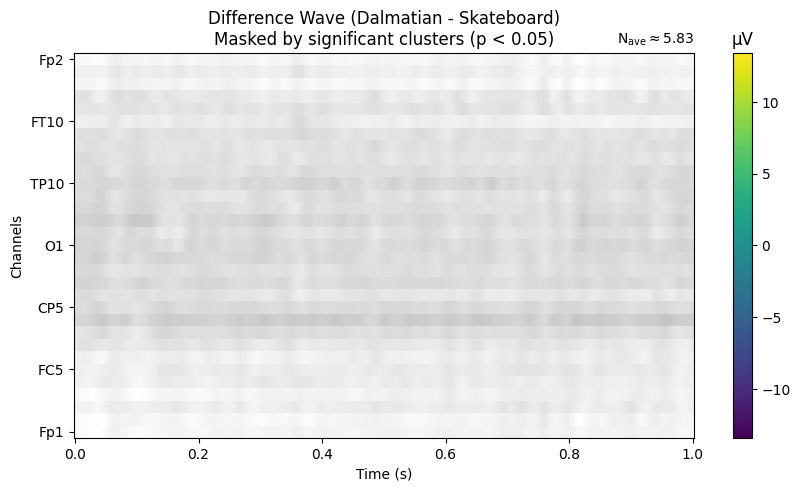

No projector specified for this dataset. Please consider the method self.add_proj.


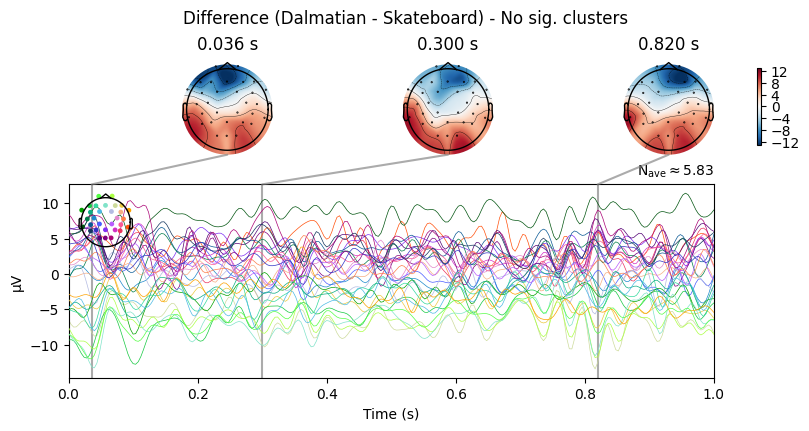

In [19]:
sig_cluster_indices = np.where(cluster_pv < p_threshold)[0]
n_sig_clusters = len(sig_cluster_indices)

print(f"\n--- Results ---")
if n_sig_clusters > 0:
    print(f"{n_sig_clusters} significant cluster(s)")
    for i in sig_cluster_indices:
        print(f"  Cluster {i}: p-value = {cluster_pv[i]:.5f}")
else:
    print("No significant clusters found")


if n_sig_clusters > 0:
    sig_clusters = [clusters[i] for i in sig_cluster_indices]
    combined_mask_time_chan = np.logical_or.reduce(sig_clusters)
    mask = combined_mask_time_chan.T 
else:
    mask = np.zeros((len(ch_names), X_dalmatian.shape[1]), dtype=bool)


evoked_dalmatian_avg = epochs_dalmatian.average()
evoked_skateboard_avg = epochs_skateboard.average()

diff_wave = mne.combine_evoked([evoked_dalmatian_avg, evoked_skateboard_avg], weights=[1, -1])


fig, ax = plt.subplots(figsize=(10, 5))
diff_wave.plot_image(
    mask=mask, 
    show_names=True, 
    show=False, 
    axes=ax,
    cmap='viridis'
)
ax.set_title("Difference Wave (Dalmatian - Skateboard)\nMasked by significant clusters (p < 0.05)")
plt.show()


if n_sig_clusters > 0:
    sig_t_values = t_obs[combined_mask_time_chan]
    sig_times_idx = np.where(combined_mask_time_chan)[0]
    peak_time_idx = sig_times_idx[np.argmax(np.abs(sig_t_values))] 
    peak_time = diff_wave.times[peak_time_idx]
    
    diff_wave.plot_joint(
        times=[peak_time], 
        title="Difference (Dalmatian - Skateboard)",
        picks='eeg'
    )
    plt.show()

else:
    diff_wave.plot_joint(title="Difference (Dalmatian - Skateboard) - No sig. clusters", picks='eeg')
    plt.show()

combining channels using "mean"
combining channels using "mean"


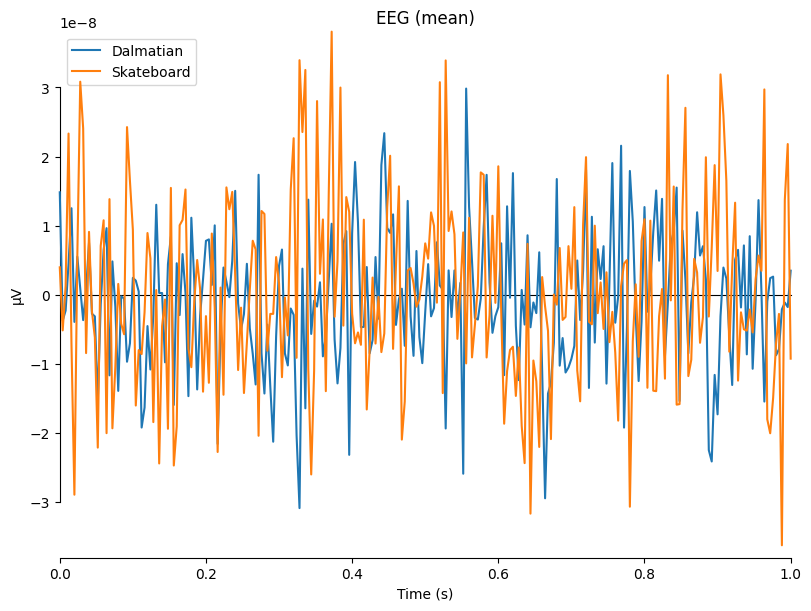

[<Figure size 800x600 with 1 Axes>]

In [20]:
mne.viz.plot_compare_evokeds(
    dict(Dalmatian=evoked_dalmatian_avg, Skateboard=evoked_skateboard_avg),
    picks='eeg',
    combine='mean'
)


In [21]:
category_counts = epochs_clean.metadata['category_name'].value_counts()
epochs_clean.metadata['category_name'].value_counts().to_csv('category_counts.csv')


supercategory
other        11604
animal         321
food           158
vehicle        133
tool           118
body_part       87
furniture       56
clothing        53
Name: count, dtype: int64
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


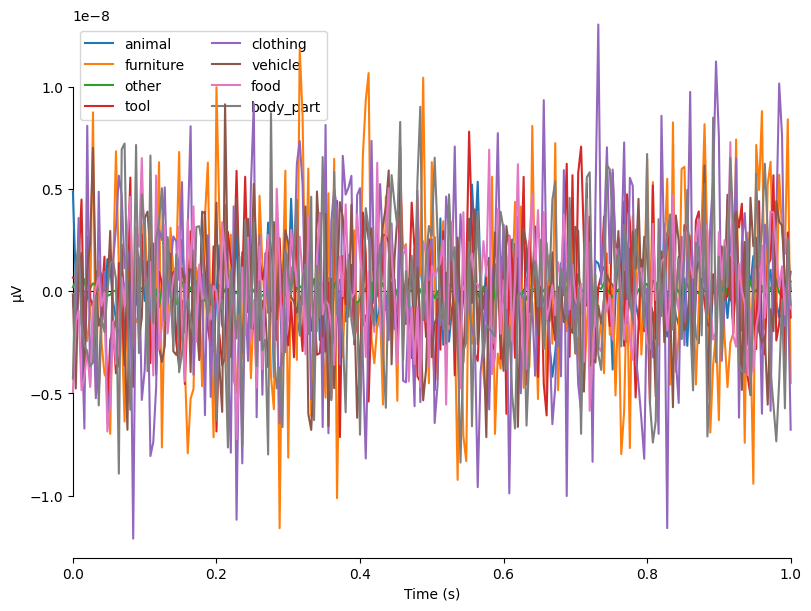

[<Figure size 800x600 with 1 Axes>]

In [22]:
category_groups = {
    "animal": [
        "dog", "dalmatian", "pug", "cat", "rabbit", "elephant", "snake",
        "wolf", "horse", "bear", "squirrel", "bird", "frog", "fish", "cow",
        "piglet", "camel", "bee", "butterfly", "goose", "chicken1", "chicken2",
        "pigeon", "antelope", "hedgehog", "sheep", "lion", "rhinoceros",
        "gorilla", "deer", "octopus", "dolphin", "whale", "penguin"
    ],
    "vehicle": [
        "car", "truck", "bus", "airplane", "bicycle", "motorcycle",
        "boat", "submarine", "train", "helicopter", "taxi", "scooter"
    ],
    "food": [
        "pizza", "sandwich", "bread", "cheese", "cake", "salad",
        "hamburger", "pasta", "ice_cream", "cookie", "apple", "banana",
        "strawberry", "chocolate", "croissant"
    ],
    "tool": [
        "hammer", "wrench", "knife", "scissors", "drill", "screwdriver",
        "shovel", "pliers", "saw", "tongs", "tape_measure", "cleaver"
    ],
    "furniture": [
        "table", "chair", "sofa", "bed", "desk", "cabinet", "stool",
        "shelf", "drawer"
    ],
    "clothing": [
        "shirt", "t-shirt", "shoe", "sock", "coat", "hat", "glove",
        "scarf", "dress", "pants"
    ],
    "body_part": [
        "hand", "face", "eye", "mouth", "leg", "arm", "nose"
    ]
}



def assign_supercategory(cat_name):
    for group, members in category_groups.items():
        if cat_name in members:
            return group
    return "other"  

epochs_clean.metadata["supercategory"] = epochs_clean.metadata["category_name"].apply(assign_supercategory)
print(epochs_clean.metadata["supercategory"].value_counts())
evokeds = {sc: epochs_clean[epochs_clean.metadata["supercategory"] == sc].average()
           for sc in epochs_clean.metadata["supercategory"].unique()}
mne.viz.plot_compare_evokeds(evokeds, combine='mean')

In [23]:
group1 = "animal"
group2 = "clothing"

X1 = epochs_clean[epochs_clean.metadata["supercategory"] == group1].get_data()
X2 = epochs_clean[epochs_clean.metadata["supercategory"] == group2].get_data()

times = epochs_clean.times

In [24]:
from mne.stats import permutation_cluster_test
X = [X1.mean(axis=1), X2.mean(axis=1)] 

T_obs, clusters, cluster_pv, H0 = permutation_cluster_test(
    X, n_permutations=1000, tail=0, n_jobs=1, out_type='mask'
)

Using a threshold of 3.866578
stat_fun(H1): min=1.0386363383872736e-05 max=9.458317952911305
Running initial clustering …
Found 13 clusters


/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4118/1771008474.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_pv, H0 = permutation_cluster_test(
100%|██████████| Permuting : 999/999 [00:00<00:00, 8738.77it/s]


Text(0.5, 1.0, 'Cluster-based permutation test: animal vs clothing')

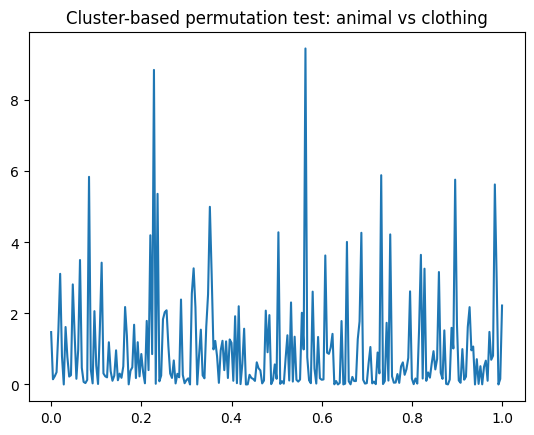

In [25]:
plt.plot(times, T_obs)
for c, p in zip(clusters, cluster_pv):
    if p < 0.05:
        plt.axvspan(times[c[0].start], times[c[0].stop - 1], color='red', alpha=0.3)
plt.title(f"Cluster-based permutation test: {group1} vs {group2}")


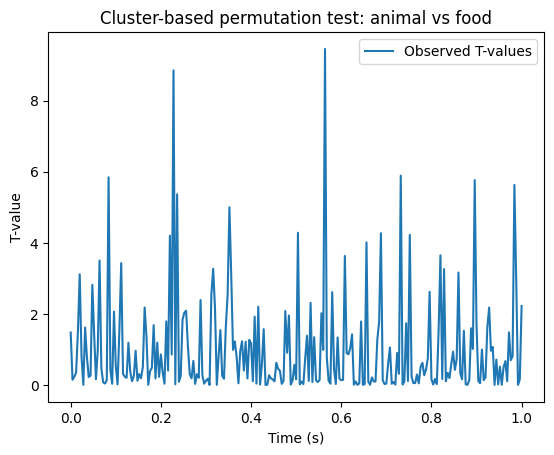

In [26]:
plt.figure()
plt.plot(times, T_obs, label="Observed T-values")
for c, p in zip(clusters, cluster_pv):
    if p < 0.05:
        h = c[0]  
        plt.axvspan(times[h.start], times[h.stop - 1],
                    color='red', alpha=0.3, label='p < 0.05')

plt.title("Cluster-based permutation test: animal vs food")
plt.xlabel("Time (s)")
plt.ylabel("T-value")
plt.legend()
plt.show()


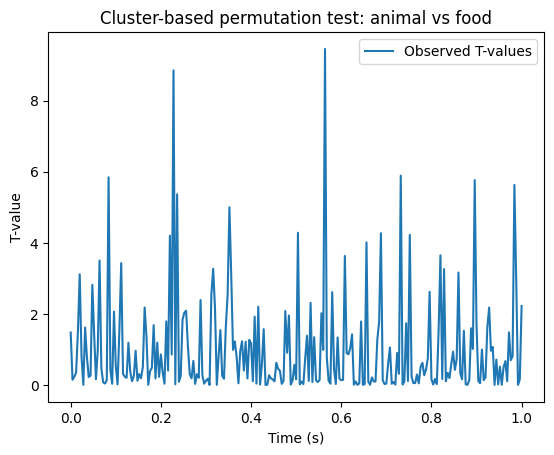

In [27]:
plt.figure()
plt.plot(times, T_obs, label="Observed T-values")
for c, p in zip(clusters, cluster_pv):
    if p < 0.05:
        h = c[0] 
        plt.axvspan(times[h.start], times[h.stop - 1],
                    color='red', alpha=0.3, label='p < 0.05 cluster')

plt.title("Cluster-based permutation test: animal vs food")
plt.xlabel("Time (s)")
plt.ylabel("T-value")
plt.legend()
plt.show()


# Retrieving semantic content from brain activity

### Strategies Considered

* PCA (principal component analysis): The data we have is pretty high dimensional, and leaves us at risk of the curse of dimensionality. PCA helps us reduce the no. of features while retaining maximum variance

* Model Complexity: Ridge regression is a linear model and is limited by its nature. A more complex deep learning model like EEGNet may be able to capture more information

* Mini batches: Each individual EEG trial is noisy, and doesn't represent the kind of signals the model would ideally learn. Averaging over mini-batches will hopefully eliminate noise and retain semantically significant signals. This shouldn't negatively affect testing, since the test data was anyway averaged (thus (I think) elinimiating noise and retaining relevant signals).

* RidgeCV, instead of ridge, can help us find the optimum regularization parameter

* Data Preprocessing: The data used in the original run above isn't preprocessed. There are several steps that can be done (band pass filtering, ICA, autoreject, etc) to make the data cleaner

* Change epoch time from 0-1 s to a more relevant interval; based on the Things EEG2 paper

Since the number of combinations of the above strategies is large, I have included only included some of them in this notebook. Also, since my data prerpocessing did not do well in the statistical steps, I tried simpler approaches here.

In [19]:
import mne
import numpy as np
import pandas as pd
import torch
import clip
from sklearn.preprocessing import RobustScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import RidgeCV
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn as nn
import torch.optim as optim
import clip
from skorch import NeuralNetRegressor
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from braindecode.models import EEGNet

### Ridge CV 

In [35]:
raw = org_raw.copy()
raw.load_data()
raw.filter(l_freq=0.1, h_freq=30.0, n_jobs=-1, verbose=False)

annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)
event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)

metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values

epochs = mne.Epochs(
    raw, 
    events, 
    tmin=-0.1, 
    tmax=0.7, 
    baseline=(None, 0), 
    preload=True, 
    verbose=False
)

epochs.resample(100)

train_mask = metadata_aligned['partition'] == 'stim_train'
test_mask = metadata_aligned['partition'] == 'stim_test'

train_data = epochs[train_mask].get_data()
train_meta = metadata_aligned[train_mask].reset_index(drop=True)

test_data = epochs[test_mask].get_data()
test_meta = metadata_aligned[test_mask].reset_index(drop=True)

def average_eeg_by_category(eeg_data, metadata):
    grouped_signals = []
    grouped_metadata = []
    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist()
        if len(indices) > 0:
            avg_signal = eeg_data[indices].mean(axis=0)
            grouped_signals.append(avg_signal)
            grouped_metadata.append(group_df.iloc[0].copy())
            
    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data, averaged_metadata

test_data_avg, test_meta_avg = average_eeg_by_category(test_data, test_meta)

X_train = train_data.reshape(train_data.shape[0], -1)
X_test = test_data_avg.reshape(test_data_avg.shape[0], -1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

unique_categories = sorted(list(set(train_meta['category_name']).union(set(test_meta_avg['category_name']))))
text_tokens = clip.tokenize(unique_categories).to(device)

with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)
    
category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}

train_targets = np.array([category_to_clip[cat] for cat in train_meta['category_name']])
test_targets = np.array([category_to_clip[cat] for cat in test_meta_avg['category_name']])

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

alphas = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 2e4, 4e4]
ridge_model = RidgeCV(alphas=alphas).fit(X_train, train_targets)

test_predictions = ridge_model.predict(X_test)

In [36]:
category_names = test_meta['category_name'].tolist()

In [37]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")

🎯 Retrieval Accuracies:
   Top-1:  0.015 (1.5%) | Chance: 0.000 (0.0%)
   Top-5:  0.135 (13.5%) | Chance: 0.001 (0.1%)
   Top-10:  0.195 (19.5%) | Chance: 0.002 (0.2%)
📊 Total test categories: 4056


### EEGNet

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()
        self.cos = nn.CosineSimilarity(dim=1)

    def forward(self, y_pred, y_true):
        return (1 - self.cos(y_pred, y_true)).mean()


raw = org_raw.copy()
raw.filter(l_freq=0.1, h_freq=30.0, n_jobs=-1, verbose=False)


annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)
event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)
metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values

epochs = mne.Epochs(
    raw, 
    events, 
    tmin=-0.1, 
    tmax=0.7, 
    baseline=(None, 0), 
    preload=True, 
    verbose=False
)
epochs.resample(100)

train_mask = metadata_aligned['partition'] == 'stim_train'
test_mask = metadata_aligned['partition'] == 'stim_test'
X_train = epochs[train_mask].get_data(copy=False).astype(np.float32)
train_meta = metadata_aligned[train_mask].reset_index(drop=True)
X_test_all_trials = epochs[test_mask].get_data(copy=False).astype(np.float32)
test_meta = metadata_aligned[test_mask].reset_index(drop=True)


def average_eeg_by_category(eeg_data, metadata):
    grouped_signals = []
    grouped_metadata = []
    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist();
        if len(indices) > 0:
            avg_signal = eeg_data[indices].mean(axis=0)
            grouped_signals.append(avg_signal)
            grouped_metadata.append(group_df.iloc[0].copy())
    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data.astype(np.float32), averaged_metadata

X_test, test_meta_avg = average_eeg_by_category(X_test_all_trials, test_meta)

clip_model, clip_preprocess = clip.load("ViT-B/32", device = device)
unique_categories = sorted(list(set(train_meta['category_name']).union(set(test_meta_avg['category_name']))))
text_tokens = clip.tokenize(unique_categories).to(device)

with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)
category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}

y_train = np.array([category_to_clip[cat] for cat in train_meta['category_name']]).astype(np.float32)
y_test = np.array([category_to_clip[cat] for cat in test_meta_avg['category_name']]).astype(np.float32)


n_chans = X_train.shape[1]
n_times = X_train.shape[2]
n_outputs = y_train.shape[1]

model = EEGNet(
    n_chans=n_chans,
    n_times=n_times,
    n_outputs=n_outputs,
    final_conv_length='auto',
    drop_prob=0.5
)

lr_scheduler = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    patience=5,
    factor=0.1
)

net = NeuralNetRegressor(
    model,
    criterion=CosineLoss, 
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    max_epochs=10, 
    batch_size=128,
    device=device,
    callbacks=[lr_scheduler],
    verbose=1
)


net.fit(X_train, y_train)


test_predictions = net.predict(X_test)

  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.3342        0.1430  0.0010  6.3538
      2        0.1448        0.1426  0.0010  6.2555
      3        0.1431        0.1497  0.0010  6.2940
      4        0.1427        0.1639  0.0010  6.3366
      5        0.1425        0.2672  0.0010  6.3295
      6        0.1424        0.4261  0.0010  6.4262
      7        0.1423        0.5499  0.0010  6.3151
      8        0.1422        0.6576  0.0010  6.5081
      9        0.1411        0.4354  0.0001  6.3234
     10        0.1410        0.2290  0.0001  6.3849


In [39]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")

🎯 Retrieval Accuracies:
   Top-1:  0.005 (0.5%) | Chance: 0.000 (0.0%)
   Top-5:  0.025 (2.5%) | Chance: 0.001 (0.1%)
   Top-10:  0.065 (6.5%) | Chance: 0.002 (0.2%)
📊 Total test categories: 4056


### LSTM

In [40]:
class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()
        self.cos = nn.CosineSimilarity(dim=1)
    def forward(self, y_pred, y_true):
        return (1 - self.cos(y_pred, y_true)).mean()

class LSTMModel(nn.Module):
    def __init__(self, n_features_in, n_features_out, n_hidden=256, n_layers=2, drop_prob=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features_in, 
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True, 
            dropout=drop_prob
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, n_features_out)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        
        last_hidden_state = hidden[-1] 
        
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out

raw = org_raw.copy()
raw.load_data()
raw.filter(l_freq=0.1, h_freq=30.0, n_jobs=-1, verbose=False)

annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)
event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)

metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values

epochs = mne.Epochs(
    raw, 
    events, 
    tmin=-0.1, 
    tmax=0.7, 
    baseline=(None, 0), 
    preload=True, 
    verbose=False
)
epochs.resample(100)

train_mask = metadata_aligned['partition'] == 'stim_train'
test_mask = metadata_aligned['partition'] == 'stim_test'

train_data = epochs[train_mask].get_data(copy=False)
train_meta = metadata_aligned[train_mask].reset_index(drop=True)

test_data = epochs[test_mask].get_data(copy=False)
test_meta = metadata_aligned[test_mask].reset_index(drop=True)

def average_eeg_by_category(eeg_data, metadata):
    grouped_signals = []
    grouped_metadata = []
    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist()
        if len(indices) > 0:
            avg_signal = eeg_data[indices].mean(axis=0)
            grouped_signals.append(avg_signal)
            grouped_metadata.append(group_df.iloc[0].copy())
    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data, averaged_metadata


test_data_avg, test_meta_avg = average_eeg_by_category(test_data, test_meta)


X_train_lstm = train_data.transpose(0, 2, 1).astype(np.float32)
X_test_lstm = test_data_avg.transpose(0, 2, 1).astype(np.float32)

n_seq, n_features_in = X_train_lstm.shape[1:] 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)


unique_categories = sorted(list(set(train_meta['category_name']).union(set(test_meta_avg['category_name']))))
text_tokens = clip.tokenize(unique_categories).to(device)

with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)
    
category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}

y_train = np.array([category_to_clip[cat] for cat in train_meta['category_name']]).astype(np.float32)
y_test = np.array([category_to_clip[cat] for cat in test_meta_avg['category_name']]).astype(np.float32)


n_outputs = y_train.shape[1] 

lr_scheduler = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    patience=5,
    factor=0.1
)

net = NeuralNetRegressor(
    LSTMModel,
    module__n_features_in=n_features_in,
    module__n_features_out=n_outputs,
    module__n_hidden=256,
    module__n_layers=2,
    module__drop_prob=0.5,
    criterion=CosineLoss,
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    max_epochs=10,
    batch_size=128,
    device=device,
    callbacks=[lr_scheduler],
    verbose=1
)


net.fit(X_train_lstm, y_train)

test_predictions = net.predict(X_test_lstm)

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        0.2788        0.1405  0.0010  14.3672
      2        0.1472        0.1402  0.0010  14.8044
      3        0.1431        0.1401  0.0010  15.4199
      4        0.1427        0.1401  0.0010  14.3462
      5        0.1424        0.1400  0.0010  13.7124
      6        0.1423        0.1400  0.0010  13.6116
      7        0.1422        0.1400  0.0010  13.4145
      8        0.1421        0.1399  0.0010  14.9587
      9        0.1420        0.1399  0.0010  13.2930
     10        0.1419        0.1399  0.0010  14.4142


In [41]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")

🎯 Retrieval Accuracies:
   Top-1:  0.005 (0.5%) | Chance: 0.000 (0.0%)
   Top-5:  0.030 (3.0%) | Chance: 0.001 (0.1%)
   Top-10:  0.060 (6.0%) | Chance: 0.002 (0.2%)
📊 Total test categories: 4056


## With more data preprocessing

In [12]:
from autoreject import get_rejection_threshold
raw = org_raw.copy()
raw.load_data()
raw.filter(l_freq=0.1, h_freq=30.0, n_jobs=-1, verbose=False)

annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)
event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)
metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values

epochs = mne.Epochs(
    raw, 
    events, 
    tmin=-0.1, 
    tmax=0.7, 
    baseline=(None, 0), 
    preload=True, 
    verbose=False
)

raw_ica = raw.copy().filter(l_freq=1.0, h_freq=30.0, n_jobs=-1, verbose=False)


tstep = 5.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(
    raw_ica, 
    events_ica, 
    tmin=0.0, 
    tmax=tstep, 
    baseline=None, 
    preload=True,
    verbose=False
)

reject_thresh_ica = get_rejection_threshold(epochs_ica, ch_types='eeg', decim=3)
epochs_ica.drop_bad(reject=reject_thresh_ica)

ica = ICA(n_components=0.99, random_state=42)
ica.fit(epochs_ica, decim=3)


eog_indices, eog_scores = ica.find_bads_eog(
    epochs_ica, 
    ch_name=['Fp1', 'Fp2', 'F7', 'F8'], 
    threshold=3.0 
)
ica.exclude = eog_indices


epochs_cleaned = ica.apply(epochs.copy())
reject_thresh_final = get_rejection_threshold(epochs_cleaned, ch_types='eeg', decim=3)
epochs_cleaned.drop_bad(reject=reject_thresh_final)

epochs_cleaned.resample(100)

/Users/soumilray/Documents/Projects/Alljoined/.venv/lib/python3.13/site-packages/autoreject/autoreject.py:242: RuntimeWarning: The measurement information indicates a low-pass frequency of 30.0 Hz. The decim=3 parameter will result in a sampling frequency of 83.33333333333333 Hz, which can cause aliasing artifacts.
  epochs.decimate(decim=decim)


Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'TP10', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'T7', 'TP9', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'T7', 'TP9', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'TP10', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejectin

/var/folders/j9/t6hw_yqj0qx1c1rhy_f7k54w0000gn/T/ipykernel_4917/3216533577.py:54: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_cleaned = ica.apply(epochs.copy())


    Transforming to ICA space (23 components)
    Zeroing out 2 ICA components
    Projecting back using 31 PCA components


/Users/soumilray/Documents/Projects/Alljoined/.venv/lib/python3.13/site-packages/autoreject/autoreject.py:242: RuntimeWarning: The measurement information indicates a low-pass frequency of 30.0 Hz. The decim=3 parameter will result in a sampling frequency of 83.33333333333333 Hz, which can cause aliasing artifacts.
  epochs.decimate(decim=decim)


Estimating rejection dictionary for eeg
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'F4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz', 'O1', 'Oz', 'F4', 'Fp2']
    Rejecting  epoch based on EEG : ['Fz', 'O1'

<Epochs | 16425 events (all good), -0.1 – 0.69 s (baseline -0.1 – 0 s), ~310.8 MiB, data loaded,
 '10': 2
 '11': 1
 '12': 2
 '13': 1
 '14': 0
 '15': 2
 '16': 2
 '17': 1
 '18': 2
 '19': 2
 and 8469 more events ...>

### Ridge CV

In [20]:
metadata_cleaned = metadata_aligned.iloc[epochs_cleaned.selection].reset_index(drop=True)

train_mask = metadata_cleaned['partition'] == 'stim_train'
test_mask = metadata_cleaned['partition'] == 'stim_test'


X_train_data = epochs_cleaned[train_mask].get_data(copy=False)
train_meta = metadata_cleaned[train_mask].reset_index(drop=True)

X_test_all_trials = epochs_cleaned[test_mask].get_data(copy=False)
test_meta = metadata_cleaned[test_mask].reset_index(drop=True)


def average_eeg_by_category(eeg_data, metadata):
    grouped_signals = []
    grouped_metadata = []
    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist();
        if len(indices) > 0:
            avg_signal = eeg_data[indices].mean(axis=0)
            grouped_signals.append(avg_signal)
            grouped_metadata.append(group_df.iloc[0].copy())
    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data, averaged_metadata

X_test_avg, test_meta_avg = average_eeg_by_category(X_test_all_trials, test_meta)


X_train = X_train_data.reshape(X_train_data.shape[0], -1)
X_test = X_test_avg.reshape(X_test_avg.shape[0], -1)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

unique_categories = sorted(list(set(train_meta['category_name']).union(set(test_meta_avg['category_name']))))
text_tokens = clip.tokenize(unique_categories).to(device)

with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)
category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}

y_train = np.array([category_to_clip[cat] for cat in train_meta['category_name']])
y_test = np.array([category_to_clip[cat] for cat in test_meta_avg['category_name']])

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

alphas = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 2e4, 4e4, 8e4] 
ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)


test_predictions = ridge_model.predict(X_test)

In [44]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")

🎯 Retrieval Accuracies:
   Top-1:  0.010 (1.0%) | Chance: 0.000 (0.0%)
   Top-5:  0.080 (8.0%) | Chance: 0.001 (0.1%)
   Top-10:  0.180 (18.0%) | Chance: 0.002 (0.2%)
📊 Total test categories: 4056


### EEGNet

In [45]:
class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()
        self.cos = nn.CosineSimilarity(dim=1)
    def forward(self, y_pred, y_true):
        return (1 - self.cos(y_pred, y_true)).mean()



metadata_cleaned = metadata_aligned.iloc[epochs_cleaned.selection].reset_index(drop=True)


train_mask = metadata_cleaned['partition'] == 'stim_train'
test_mask = metadata_cleaned['partition'] == 'stim_test'


X_train = epochs_cleaned[train_mask].get_data(copy=False).astype(np.float32)
train_meta = metadata_cleaned[train_mask].reset_index(drop=True)

X_test_all_trials = epochs_cleaned[test_mask].get_data(copy=False).astype(np.float32)
test_meta = metadata_cleaned[test_mask].reset_index(drop=True)



def average_eeg_by_category(eeg_data, metadata):
    grouped_signals = []
    grouped_metadata = []
    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist();
        if len(indices) > 0:
            avg_signal = eeg_data[indices].mean(axis=0)
            grouped_signals.append(avg_signal)
            grouped_metadata.append(group_df.iloc[0].copy())
    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data.astype(np.float32), averaged_metadata


X_test, test_meta_avg = average_eeg_by_category(X_test_all_trials, test_meta)


clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

unique_categories = sorted(list(set(train_meta['category_name']).union(set(test_meta_avg['category_name']))))
text_tokens = clip.tokenize(unique_categories).to(device)

with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)
category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}


y_train = np.array([category_to_clip[cat] for cat in train_meta['category_name']]).astype(np.float32)
y_test = np.array([category_to_clip[cat] for cat in test_meta_avg['category_name']]).astype(np.float32)


n_chans = X_train.shape[1]
n_times = X_train.shape[2]
n_outputs = y_train.shape[1] 

model = EEGNet(
    n_chans=n_chans,
    n_times=n_times,
    n_outputs=n_outputs,
    final_conv_length='auto',
    drop_prob=0.5 
)

lr_scheduler = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    patience=5,
    factor=0.1
)

net = NeuralNetRegressor(
    model,
    criterion=CosineLoss,
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    max_epochs=10,
    batch_size=128,
    device=device,
    callbacks=[lr_scheduler],
    verbose=1
)


net.fit(X_train, y_train)


test_predictions = net.predict(X_test)


  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        0.3650        0.1453  0.0010  4.8648
      2        0.1434        0.1428  0.0010  4.8275
      3        0.1429        0.1939  0.0010  4.8852
      4        0.1427        0.1760  0.0010  4.8542
      5        0.1426        0.1799  0.0010  4.8765
      6        0.1424        0.2939  0.0010  4.8739
      7        0.1423        0.3706  0.0010  4.9256
      8        0.1423        0.3846  0.0010  5.0981
      9        0.1411        0.2724  0.0001  4.9117
     10        0.1410        0.2448  0.0001  5.1224


In [46]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")

🎯 Retrieval Accuracies:
   Top-1:  0.005 (0.5%) | Chance: 0.000 (0.0%)
   Top-5:  0.020 (2.0%) | Chance: 0.001 (0.1%)
   Top-10:  0.065 (6.5%) | Chance: 0.002 (0.2%)
📊 Total test categories: 4056


### LSTM

In [47]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import clip
from skorch import NeuralNetRegressor
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics.pairwise import cosine_similarity


class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()
        self.cos = nn.CosineSimilarity(dim=1)
    def forward(self, y_pred, y_true):
        return (1 - self.cos(y_pred, y_true)).mean()


class LSTMModel(nn.Module):
    def __init__(self, n_features_in, n_features_out, n_hidden=256, n_layers=2, drop_prob=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features_in, 
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True, 
            dropout=drop_prob
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, n_features_out)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        last_hidden_state = hidden[-1] 
        
        out = self.dropout(last_hidden_state)
        out = self.fc(out)
        return out

metadata_cleaned = metadata_aligned.iloc[epochs_cleaned.selection].reset_index(drop=True)

train_mask = metadata_cleaned['partition'] == 'stim_train'
test_mask = metadata_cleaned['partition'] == 'stim_test'


X_train_data = epochs_cleaned[train_mask].get_data(copy=False)
train_meta = metadata_cleaned[train_mask].reset_index(drop=True)
X_test_all_trials = epochs_cleaned[test_mask].get_data(copy=False)
test_meta = metadata_cleaned[test_mask].reset_index(drop=True)


def average_eeg_by_category(eeg_data, metadata):
    grouped_signals = []
    grouped_metadata = []
    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist();
        if len(indices) > 0:
            avg_signal = eeg_data[indices].mean(axis=0)
            grouped_signals.append(avg_signal)
            grouped_metadata.append(group_df.iloc[0].copy())
    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data, averaged_metadata

X_test_avg, test_meta_avg = average_eeg_by_category(X_test_all_trials, test_meta)


X_train_lstm = X_train_data.transpose(0, 2, 1).astype(np.float32)
X_test_lstm = X_test_avg.transpose(0, 2, 1).astype(np.float32)

n_seq, n_features_in = X_train_lstm.shape[1:] 


device = 'cuda' if torch.cuda.is_available() else 'cpu'
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
unique_categories = sorted(list(set(train_meta['category_name']).union(set(test_meta_avg['category_name']))))
text_tokens = clip.tokenize(unique_categories).to(device)
with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)
category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}

y_train = np.array([category_to_clip[cat] for cat in train_meta['category_name']]).astype(np.float32)
y_test = np.array([category_to_clip[cat] for cat in test_meta_avg['category_name']]).astype(np.float32)


n_outputs = y_train.shape[1]

lr_scheduler = LRScheduler(
    policy=ReduceLROnPlateau,
    monitor='valid_loss',
    patience=5,
    factor=0.1
)

net = NeuralNetRegressor(
    LSTMModel,
    module__n_features_in=n_features_in,
    module__n_features_out=n_outputs,
    module__n_hidden=256,
    module__n_layers=2,
    module__drop_prob=0.5,
    criterion=CosineLoss,
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    max_epochs=10,
    batch_size=128,
    device=device,
    callbacks=[lr_scheduler],
    verbose=1
)


net.fit(X_train_lstm, y_train)


test_predictions = net.predict(X_test_lstm)


  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        0.2946        0.1412  0.0010  10.6594
      2        0.1546        0.1407  0.0010  10.4359
      3        0.1439        0.1405  0.0010  10.4658
      4        0.1430        0.1404  0.0010  10.4318
      5        0.1427        0.1403  0.0010  10.4357
      6        0.1424        0.1403  0.0010  10.4148
      7        0.1423        0.1403  0.0010  10.4335
      8        0.1422        0.1403  0.0010  10.4183
      9        0.1421        0.1402  0.0010  10.4323
     10        0.1420        0.1402  0.0010  10.4117


In [48]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")

🎯 Retrieval Accuracies:
   Top-1:  0.005 (0.5%) | Chance: 0.000 (0.0%)
   Top-5:  0.050 (5.0%) | Chance: 0.001 (0.1%)
   Top-10:  0.065 (6.5%) | Chance: 0.002 (0.2%)
📊 Total test categories: 4056


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

metadata_cleaned = metadata_aligned.iloc[epochs_cleaned.selection].reset_index(drop=True)

train_mask = metadata_cleaned['partition'] == 'stim_train'
test_mask = metadata_cleaned['partition'] == 'stim_test'


X_train_data = epochs_cleaned[train_mask].get_data(copy=False)
train_meta = metadata_cleaned[train_mask].reset_index(drop=True)
X_test_all_trials = epochs_cleaned[test_mask].get_data(copy=False)
test_meta = metadata_cleaned[test_mask].reset_index(drop=True)


X_train = X_train_data.reshape(len(X_train_data), -1)
X_test  = X_test_all_trials.reshape(len(X_test_all_trials), -1)


rf_model = RandomForestRegressor(
    n_estimators=100,     
    max_depth=10,       
    random_state=42,
    verbose=1            
)
rf_model.fit(X_train, y_train)


test_predictions = rf_model.predict(X_test)

In [ ]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")